In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "Lesson05"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Decision Trees

---

**Decision Trees** are versatile Machine Learning algorithms that can perform
both classification and regression tasks, and even multioutput tasks.
They are very powerful algorithms, capable of fitting complex datasets.

>One of the many qualities of Decision Trees is that they require very little data preparation. In particular, they don’t require feature scaling or centering at all

## Training and Visualizing a Decision Tree

To understand Decision Trees, let’s just build a `DecisionTreeClassifier` on the iris dataset and take a look at how it makes predictions.


In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

# Making Predictions

To see how a trained Decision Tree makes prediction, we can visualize it by first using the export_graphviz()
method to output a graph definition file called *iris_tree.dot*

In [4]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=str(IMAGES_PATH / "iris_tree.dot"),  # path differs in the book
        feature_names=["petal length (cm)", "petal width (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

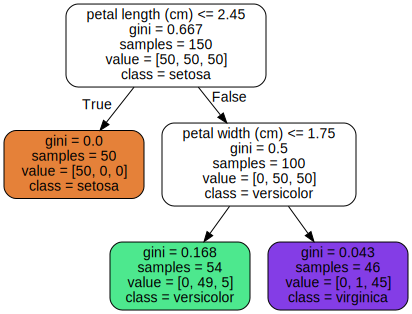

In [5]:
# This package calls the graphviz visualization software. 
# So, to run this cell and the next one, you need to install graphviz on your machine first.
from graphviz import Source

Source.from_file(IMAGES_PATH / "iris_tree.dot")  # path differs in the book

Graphviz also provides the `dot` command line tool to convert `.dot` files to a variety of formats. The following command converts the dot file to a png image:

In [6]:
# extra code
!dot -Tpng {IMAGES_PATH / "iris_tree.dot"} -o {IMAGES_PATH / "iris_tree.png"}

- A node’s **samples** attribute counts how many training instances it applies to. For
example, 100 training instances have a petal length greater than 2.45 cm (depth 1,
right), among which 54 have a petal width smaller than 1.75 cm (depth 2, left). 

- A node’s **value** attribute tells you how many training instances of each class this node
applies to: for example, the bottom-right node applies to 0 Iris-Setosa, 1 Iris-
Versicolor, and 45 Iris-Virginica. 

- Finally, a node’s **gini** attribute measures its impurity: a node is “pure” (gini=0) if all training instances it applies to belong to the same class.

>**Gini impurity**
>$$ G_i = 1 - \Sigma_{k=1}^{n} p_{i,k}^2 $$ 
>where $p_{i,k}$  is the ratio of class $k$ instances among the training instances in the $i^{th}$ node.



If we plot the Decision Tree's decision boundaries, we can see that the thick vertical line represents
the decision boundary of the root node (depth 0): petal length = 2.45 cm.
Since the left area is pure (only Iris-Setosa), it cannot be split any further. 
However, the right area is impure, so the depth-1 right node splits it at petal width = 1.75 cm
(represented by the dashed line). Since max_depth was set to 2, the Decision Tree
stops right there. 

If we set max_depth to 3, then the two depth-2 nodes would each add another decision boundary (represented by the dotted lines).

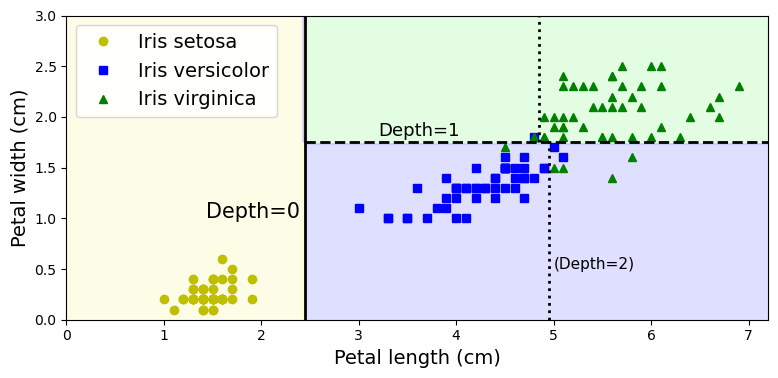

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# just formatting details
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

# Here, we train Decision tree with max depth set to 3
tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)
plt.axis([0, 7.2, 0, 3])
plt.legend()
save_fig("decision_tree_decision_boundaries_plot")

plt.show()

You can access the tree structure via the `tree_` attribute:

In [8]:
tree_clf.tree_

#### Model Interpretation: White Box Versus Black Box

As you can see Decision Trees are fairly intuitive and their decisions are easy to interpret.
Such models are often called white box models. In contrast, as we will see, neural networks are generally considered black box models. They
make great predictions, and you can easily check the calculations that they performed
to make these predictions; nevertheless, it is usually hard to explain in simple terms
why the predictions were made.

### Classification And Regression Tree (CART) algorithm

Scikit-Learn uses the **CART** algorithm, which produces only binary
trees: nonleaf nodes always have two children (i.e., questions only
have yes/no answers). 

(However, other algorithms such as **ID3** can produce Decision Trees with nodes that have more than two children.)

The idea of CART is really quite simple: the algorithm first splits the training set in two subsets using a single feature $k$ and a threshold $t_k$ (e.g., “petal length ≤ 2.45 cm”). To do this, it searches for the pair $(k, t_k)$ that produces the purest subsets.

Once it has successfully split the training set in two, it splits the subsets using the same logic, then the sub-subsets and so on, recursively.

>**CART** cost function for classification
>
>$$
J(k,t_k) = \frac{m_{\mathrm{left}}}{m} G_{\mathrm{left}} + \frac{m_{\mathrm{right}}}{m} G_{\mathrm{right}}
$$
>where $G_{\mathrm{left/right}}$ measures the impurity of the left/right subset, and $m_{\mathrm{left/right}} $ is the number of instances in the left/right subset.

Since each node only requires checking the value of one feature, the overall prediction complexity is just $O(\log_2(m))$,
independent of the number of features. So predictions are very fast, even when dealing
with large training sets.

However, the training algorithm compares all features (or less if max_features is set) on all samples at each node. This results in a training complexity of $O(n \times m \log(m))$.
For small training sets (less than a few thousand instances), Scikit-Learn can speed up training by presorting the data (set presort=True), but this slows down training considerably for larger training sets.

# Estimating Class Probabilities

A Decision Tree can also estimate the probability that an instance belongs to a particular
class $k$: first it traverses the tree to find the leaf node for this instance, and then it
returns the ratio of training instances of class $k$ in this node.

In [9]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [10]:
tree_clf.predict([[5, 1.5]])

array([1])

# Regularization Hyperparameters

Decision Trees make very few assumptions about the training data (as opposed to linear
models, which obviously assume that the data is linear, for example).

If left unconstrained, the tree structure will adapt itself to the training data, fitting it very
closely, and most likely overfitting it. Such a model is often called a *nonparametric*
model, not because it does not have any parameters (it often has a lot) but because the
number of parameters is not determined prior to training, so the model structure is
free to stick closely to the data. 



In contrast, a *parametric* model such as a linear model has a predetermined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting (but increasing the risk of underfitting).

The regularization hyperparameters depend on the algorithm used, but generally we can at least restrict the maximum depth of the Decision Tree. In `Scikit-Learn`, reducing `max_depth` hyperparameter will regularize the model and thus reduce the risk of overfitting.




The `DecisionTreeClassifier` class has a few other parameters that similarly restrict the shape of the Decision Tree: 

- `min_samples_split`: the minimum number of samples a node must have before it can be split, 
- `min_samples_leaf`: the minimum number of samples a leaf node must have,
- `min_weight_fraction_leaf`: same as `min_samples_leaf` but expressed as a fraction of the total number of weighted instances, 
- `max_leaf_nodes`: maximum number of leaf nodes, 
- `max_features`: maximum number of features that are evaluated for splitting at each node. 


In [11]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

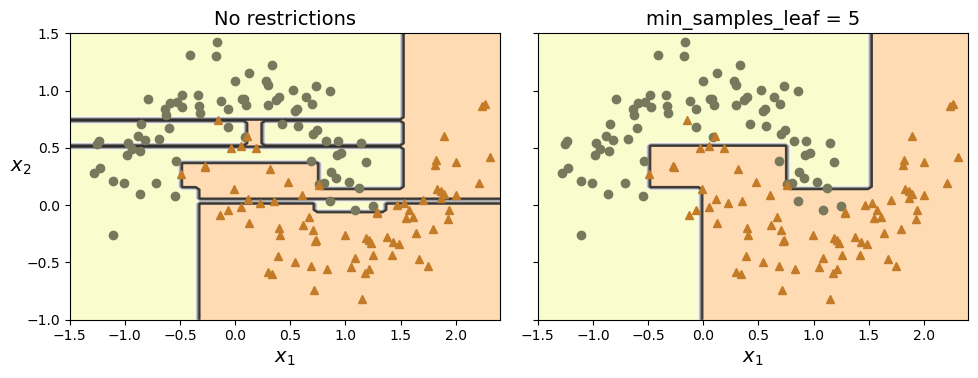

In [12]:
def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")
save_fig("min_samples_leaf_plot")
plt.show()

In [13]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2,
                                        random_state=43)
tree_clf1.score(X_moons_test, y_moons_test)

0.898

In [14]:
tree_clf2.score(X_moons_test, y_moons_test)

0.92

## Instability

`Decision Trees` are simple to understand and interpret, easy to use, versatile, and powerful.

However they do have a few limitations. 

### Sensitivity to axis orientation

First, Decision Trees love orthogonal decision boundaries (perpendicular to an axis).
So, rotating the dataset also leads to completely different decision boundaries:

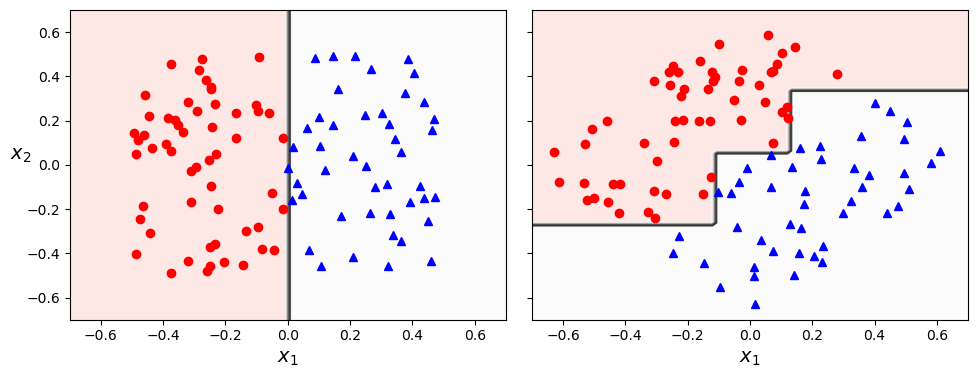

In [15]:
np.random.seed(6)
X_square = np.random.rand(100, 2) - 0.5
y_square = (X_square[:, 0] > 0).astype(np.int64)

angle = np.pi / 4  # 45 degrees
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
X_rotated_square = X_square.dot(rotation_matrix)

tree_clf_square = DecisionTreeClassifier(random_state=42)
tree_clf_square.fit(X_square, y_square)
tree_clf_rotated_square = DecisionTreeClassifier(random_state=42)
tree_clf_rotated_square.fit(X_rotated_square, y_square)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_square, X_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.sca(axes[1])
plot_decision_boundary(tree_clf_rotated_square, X_rotated_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

After rotation, the decision boundary looks unnecessarily convoluted.
Although it fits the training set perfectly, it is very likely that the model on the right will not generalize well.

>One way to limit this problem is to scale the data then apply a Principal Component Analysis tranformation, which often results in a better orientation of the training data.

### Decision Trees Have High Variance

More generally, the main issue with Decision Trees is that they have quite a high variance: 
>small changes to the hyperparameters or to the data may produce very different models.

Indeed, the training the same model on the same data may produce a very different model every time, since the CART training algorithm used by `Scikit-Learn` is stochastic. To show this, we will set `random_state` to a different value than earlier:

In [16]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=40)

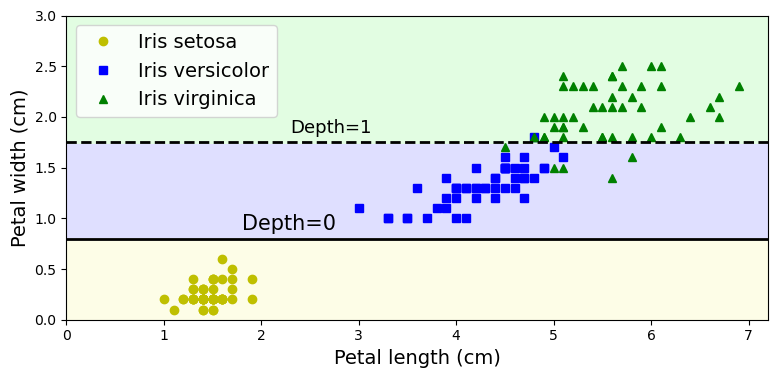

In [17]:
plt.figure(figsize=(8, 4))
y_pred = tree_clf_tweaked.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)

for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

th0, th1 = tree_clf_tweaked.tree_.threshold[[0, 2]]
plt.plot([0, 7.2], [th0, th0], "k-", linewidth=2)
plt.plot([0, 7.2], [th1, th1], "k--", linewidth=2)
plt.text(1.8, th0 + 0.05, "Depth=0", verticalalignment="bottom", fontsize=15)
plt.text(2.3, th1 + 0.05, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.axis([0, 7.2, 0, 3])
plt.legend()
save_fig("decision_tree_high_variance_plot")

plt.show()